In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/Kaggle_Quora_Project/train_csv.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Kaggle_Quora_Project/train_csv.zip
  inflating: train.csv               


In [3]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 131.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=ac6e643b65be1fde5a0c6464bd36b5be1f4768fd2432f441d4a9089918b40d4a
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
import torch
from sentence_transformers import util
from sentence_transformers import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator
from sentence_transformers import InputExample
import math

In [5]:
def read_data(filename,encoding="utf8"):
    df = pd.read_csv(filename)
    # Drop null values
    df.dropna(inplace=True)
    df.reset_index(drop=True,inplace=True)
    print("\nNumber of records:",len(df))
    return df

df = read_data("train.csv")
df = df[['question1', 'question2', 'is_duplicate']]
df.head()


Number of records: 404287


,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
new_df = df.sample(30000)
new_df_copy = new_df.copy()
new_df.head()

,question1,question2,is_duplicate
246725,Which course is best CA or US CMA?,What is the meaning of this Meer Taqi Meer Urd...,0
183523,Is the Korean War a hoax?,Will there be a second Korean war?,0
188533,Which philosopher has influenced you the most?,Who is the most interesting Humean philosopher?,0
272269,What should a person do when everything goes w...,What do I do when nothing goes right in life?,1
264751,What are some examples of people using the sci...,How can one use the scientific method to test ...,0


In [7]:
new_df['is_duplicate'].value_counts()

0    18778
1    11222
Name: is_duplicate, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

df_train,df_dev = train_test_split(new_df_copy,
                                   test_size=0.2,
                                   stratify=new_df['is_duplicate'],
                                   random_state=42)

df_train.reset_index(drop=True,inplace=True)
df_dev.reset_index(drop=True,inplace=True)

print("Train data shape:",df_train.shape)
print("Dev data shape:",df_dev.shape)

Train data shape: (24000, 3)
Dev data shape: (6000, 3)


In [9]:
def create_samples(data):
    samples = []
    for i in range(len(data)):
        samples.append(InputExample(texts=[data.loc[i,"question1"],data.loc[i,"question2"]],
                                              label=int(data.loc[i,"is_duplicate"])))
    return samples


In [10]:
train_samples = create_samples(df_train)
dev_samples = create_samples(df_dev)

print("Number of train samples:",len(train_samples))
print("Number of dev samples:",len(dev_samples))


Number of train samples: 24000
Number of dev samples: 6000


In [11]:
train_batch_size = 16
num_epochs = 4
model_path = "/content/drive/MyDrive/Kaggle_Quora_Project/model_quora"


model = CrossEncoder(model_name="distilroberta-base", num_labels=1)

train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)

evaluator = CEBinaryClassificationEvaluator.from_input_examples(dev_samples, name='Quora-dev')

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up

model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=5000,
          warmup_steps=warmup_steps,
          output_path=model_path,
          show_progress_bar=True)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias'

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

In [12]:
train = [] # create list of train data question pairs
for i in range(len(df_train)):
    train.append([df_train.loc[i,'question1'],df_train.loc[i,'question2']])

predictions = model.predict(train,show_progress_bar=True)
predictions

Batches:   0%|          | 0/750 [00:00<?, ?it/s]

array([9.8775315e-01, 9.8420745e-01, 4.7673125e-04, ..., 1.2824346e-01,
       4.6023677e-04, 5.4294295e-03], dtype=float32)

In [13]:
cosine_sim = list(predictions)
df_1 = df_train.copy()
df_1['cosine_sim'] = cosine_sim # Add a column for cosine similarity to a copy of train data
df_1.head()

,question1,question2,is_duplicate,cosine_sim
0,What is the transformer?,What is a transformer?,1,0.987753
1,How can I tell if she likes me?,How do I tell if she likes me?,1,0.984207
2,Have you flirted with a flight attendant and s...,Who is the most badass person you've ever met/...,0,0.000477
3,How can we remove reservation from the Indian ...,Who has power to remove reservation in constit...,1,0.991507
4,I'm doing a Walmart purchase online so how do ...,How do I apply my Walmart employee discount on...,1,0.970123


In [14]:
# Model building using XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix


X = df_1[['cosine_sim']]
y = df_1['is_duplicate']

model_xgb = XGBClassifier()
model_xgb.fit(X,y)

# Check accuracy on dev set

dev = []
for i in range(len(df_dev)):
    dev.append([df_dev.loc[i,'question1'],df_dev.loc[i,'question2']])

predictions = model.predict(dev,show_progress_bar=True)
df_2 = df_dev.copy()
df_2["cosine_sim"] = list(predictions)
X_dev = df_2[["cosine_sim"]]
y_dev = df_2["is_duplicate"]

y_predict_xgb = model_xgb.predict(X_dev)

print('Accuracy Score:',accuracy_score(y_dev,y_predict_xgb))

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

Accuracy Score: 0.8541666666666666


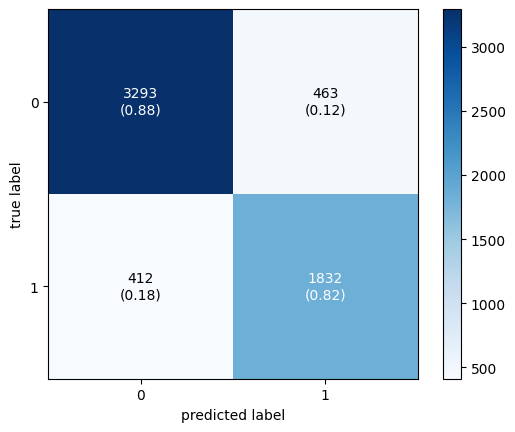

In [15]:
cm = confusion_matrix(y_dev,y_predict_xgb)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

In [16]:
print("\t\tClassification Report:\n\n",classification_report(y_dev,y_predict_xgb))

		Classification Report:

               precision    recall  f1-score   support

           0       0.89      0.88      0.88      3756
           1       0.80      0.82      0.81      2244

    accuracy                           0.85      6000
   macro avg       0.84      0.85      0.84      6000
weighted avg       0.85      0.85      0.85      6000

